In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        return logits

In [6]:
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        return logits

In [8]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ###############################################
    next_states_logits = generator(actions=actions_logits, hidden_size=hidden_size, state_size=state_size)
    next_states_labels = tf.nn.sigmoid(next_states)
    aloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits, 
                                                                    labels=next_states_labels))
    ####################################################
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, action_size=action_size)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    ####################################################
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states, action_size=action_size, 
                        reuse=True)
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.ones_like(gQs))) # 0-1
    ############################################################################
    next_actions_logits = actor(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    nextQs_logits = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states, 
                                  action_size=action_size, reuse=True)
    nextQs = tf.reshape(nextQs_logits, shape=[-1]) * dones
    targetQs = rewards + (gamma * nextQs)
    aloss3 = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, aloss, dloss, aloss2, aloss3

In [9]:
def model_opt(a_loss, a_loss2, a_loss3, d_loss, a_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('actor')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
        a_opt3 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss3, var_list=a_vars)
    return a_opt, d_opt, a_opt2, a_opt3

In [10]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, d_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.d_loss, self.a_loss2, self.a_loss3 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, #model input 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.d_opt, self.a_opt2, self.a_opt3 = model_opt(a_loss=self.a_loss, 
                                                                     a_loss2=self.a_loss2, 
                                                                     a_loss3=self.a_loss3, 
                                                                     d_loss=self.d_loss,
                                                                     a_learning_rate=a_learning_rate,
                                                                     d_learning_rate=d_learning_rate)

In [19]:
# def sample(buffer, batch_size):
#     idx = np.random.choice(np.arange(len(buffer)), size=batch_size, replace=False)
#     return [buffer[ii] for ii in idx]

In [20]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [21]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [22]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e2)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [23]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, d_learning_rate=d_learning_rate, gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

In [24]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# aloss_list, dloss_list, aloss2_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0 # each episode
        aloss_batch, dloss_batch, aloss2_batch, aloss3_batch = [], [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            rate = -1
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.sample(batch_size=batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            rates = np.array([each[5] for each in batch])
            aloss, dloss, _, _ = sess.run([model.a_loss, model.d_loss, model.a_opt, model.d_opt],
                                          feed_dict = {model.states: states, 
                                                       model.actions: actions,
                                                       model.next_states: next_states,
                                                       model.rewards: rewards,
                                                       model.dones: dones,
                                                       model.rates: rates})
            aloss2, _ = sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            aloss3, _ = sess.run([model.a_loss3, model.a_opt3], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            aloss_batch.append(aloss)
            dloss_batch.append(dloss)
            aloss2_batch.append(aloss2)
            aloss3_batch.append(aloss3)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'aloss3:{:.4f}'.format(np.mean(aloss3_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:10.0000 R:10.0000 rate:0.0200 aloss:1.5056 dloss:0.7783 aloss2:0.6052 aloss3:0.7509 exploreP:0.9990
Episode:1 meanR:10.5000 R:11.0000 rate:0.0220 aloss:1.4675 dloss:0.7766 aloss2:0.6144 aloss3:0.7380 exploreP:0.9979
Episode:2 meanR:17.6667 R:32.0000 rate:0.0640 aloss:1.4669 dloss:0.7650 aloss2:0.6262 aloss3:0.7869 exploreP:0.9948
Episode:3 meanR:17.2500 R:16.0000 rate:0.0320 aloss:1.4468 dloss:0.7549 aloss2:0.6410 aloss3:0.8149 exploreP:0.9932
Episode:4 meanR:17.6000 R:19.0000 rate:0.0380 aloss:1.4603 dloss:0.7423 aloss2:0.6494 aloss3:0.8669 exploreP:0.9913
Episode:5 meanR:18.1667 R:21.0000 rate:0.0420 aloss:1.4494 dloss:0.7381 aloss2:0.6625 aloss3:0.8769 exploreP:0.9893
Episode:6 meanR:17.2857 R:12.0000 rate:0.0240 aloss:1.4388 dloss:0.7278 aloss2:0.6684 aloss3:0.9126 exploreP:0.9881
Episode:7 meanR:17.2500 R:17.0000 rate:0.0340 aloss:1.4443 dloss:0.7189 aloss2:0.6742 aloss3:0.9498 exploreP:0.9864
Episode:8 meanR:19.2222 R:35.0000 rate:0.0700 aloss:1.4377 dloss:0.7081 

Episode:71 meanR:25.3889 R:37.0000 rate:0.0740 aloss:1.3967 dloss:0.2617 aloss2:1.6603 aloss3:8.6070 exploreP:0.8346
Episode:72 meanR:25.2192 R:13.0000 rate:0.0260 aloss:1.3930 dloss:0.2612 aloss2:1.6758 aloss3:8.7468 exploreP:0.8335
Episode:73 meanR:25.0541 R:13.0000 rate:0.0260 aloss:1.3942 dloss:0.2638 aloss2:1.6564 aloss3:8.6647 exploreP:0.8325
Episode:74 meanR:24.8800 R:12.0000 rate:0.0240 aloss:1.3990 dloss:0.2630 aloss2:1.6783 aloss3:8.7524 exploreP:0.8315
Episode:75 meanR:24.6711 R:9.0000 rate:0.0180 aloss:1.4001 dloss:0.2585 aloss2:1.6846 aloss3:9.0229 exploreP:0.8307
Episode:76 meanR:24.5844 R:18.0000 rate:0.0360 aloss:1.4016 dloss:0.2564 aloss2:1.7052 aloss3:9.1540 exploreP:0.8293
Episode:77 meanR:24.5256 R:20.0000 rate:0.0400 aloss:1.3991 dloss:0.2580 aloss2:1.6970 aloss3:9.0807 exploreP:0.8276
Episode:78 meanR:24.3291 R:9.0000 rate:0.0180 aloss:1.4029 dloss:0.2502 aloss2:1.7285 aloss3:9.3887 exploreP:0.8269
Episode:79 meanR:24.3625 R:27.0000 rate:0.0540 aloss:1.3989 dloss:

Episode:141 meanR:20.4000 R:11.0000 rate:0.0220 aloss:1.3903 dloss:0.2220 aloss2:2.0277 aloss3:13.5557 exploreP:0.7303
Episode:142 meanR:20.4300 R:18.0000 rate:0.0360 aloss:1.3938 dloss:0.2199 aloss2:2.0390 aloss3:13.7017 exploreP:0.7290
Episode:143 meanR:20.6600 R:46.0000 rate:0.0920 aloss:1.3935 dloss:0.2222 aloss2:2.0343 aloss3:13.7455 exploreP:0.7257
Episode:144 meanR:20.6800 R:22.0000 rate:0.0440 aloss:1.3938 dloss:0.2208 aloss2:2.0317 aloss3:13.6778 exploreP:0.7242
Episode:145 meanR:20.8500 R:26.0000 rate:0.0520 aloss:1.3903 dloss:0.2218 aloss2:2.0288 aloss3:13.6903 exploreP:0.7223
Episode:146 meanR:20.9000 R:16.0000 rate:0.0320 aloss:1.3935 dloss:0.2243 aloss2:2.0290 aloss3:13.7353 exploreP:0.7212
Episode:147 meanR:20.9100 R:15.0000 rate:0.0300 aloss:1.3925 dloss:0.2144 aloss2:2.0344 aloss3:13.6874 exploreP:0.7201
Episode:148 meanR:20.7200 R:13.0000 rate:0.0260 aloss:1.3918 dloss:0.2228 aloss2:2.0286 aloss3:13.6832 exploreP:0.7192
Episode:149 meanR:20.7400 R:12.0000 rate:0.0240 

Episode:210 meanR:17.5600 R:11.0000 rate:0.0220 aloss:1.3900 dloss:0.2185 aloss2:1.9974 aloss3:14.0184 exploreP:0.6502
Episode:211 meanR:17.2900 R:18.0000 rate:0.0360 aloss:1.3893 dloss:0.2213 aloss2:2.0006 aloss3:14.0263 exploreP:0.6491
Episode:212 meanR:17.2700 R:18.0000 rate:0.0360 aloss:1.3898 dloss:0.2131 aloss2:1.9990 aloss3:14.0046 exploreP:0.6479
Episode:213 meanR:17.2200 R:10.0000 rate:0.0200 aloss:1.3908 dloss:0.2181 aloss2:2.0009 aloss3:13.9180 exploreP:0.6473
Episode:214 meanR:17.2300 R:12.0000 rate:0.0240 aloss:1.3923 dloss:0.2185 aloss2:2.0049 aloss3:14.0939 exploreP:0.6465
Episode:215 meanR:17.2000 R:12.0000 rate:0.0240 aloss:1.3933 dloss:0.2167 aloss2:2.0044 aloss3:14.0747 exploreP:0.6457
Episode:216 meanR:16.9100 R:13.0000 rate:0.0260 aloss:1.3898 dloss:0.2218 aloss2:2.0005 aloss3:14.1576 exploreP:0.6449
Episode:217 meanR:16.9900 R:17.0000 rate:0.0340 aloss:1.3910 dloss:0.2171 aloss2:1.9979 aloss3:14.0363 exploreP:0.6438
Episode:218 meanR:16.9800 R:12.0000 rate:0.0240 

Episode:280 meanR:15.0400 R:12.0000 rate:0.0240 aloss:1.3916 dloss:0.2148 aloss2:1.9892 aloss3:14.0412 exploreP:0.5861
Episode:281 meanR:15.0500 R:12.0000 rate:0.0240 aloss:1.3914 dloss:0.2179 aloss2:1.9859 aloss3:14.2090 exploreP:0.5854
Episode:282 meanR:15.0600 R:12.0000 rate:0.0240 aloss:1.3908 dloss:0.2195 aloss2:1.9874 aloss3:14.1322 exploreP:0.5847
Episode:283 meanR:14.8600 R:16.0000 rate:0.0320 aloss:1.3905 dloss:0.2145 aloss2:1.9807 aloss3:14.2054 exploreP:0.5838
Episode:284 meanR:14.8900 R:18.0000 rate:0.0360 aloss:1.3887 dloss:0.2193 aloss2:1.9808 aloss3:14.2227 exploreP:0.5827
Episode:285 meanR:14.8700 R:11.0000 rate:0.0220 aloss:1.3908 dloss:0.2181 aloss2:1.9808 aloss3:14.1915 exploreP:0.5821
Episode:286 meanR:14.9200 R:16.0000 rate:0.0320 aloss:1.3897 dloss:0.2153 aloss2:1.9775 aloss3:14.1705 exploreP:0.5812
Episode:287 meanR:14.9200 R:16.0000 rate:0.0320 aloss:1.3900 dloss:0.2180 aloss2:1.9801 aloss3:14.0765 exploreP:0.5803
Episode:288 meanR:14.9100 R:13.0000 rate:0.0260 

Episode:349 meanR:14.6500 R:9.0000 rate:0.0180 aloss:1.3878 dloss:0.2130 aloss2:1.9563 aloss3:14.2379 exploreP:0.5330
Episode:350 meanR:14.5300 R:13.0000 rate:0.0260 aloss:1.3897 dloss:0.2151 aloss2:1.9577 aloss3:14.1493 exploreP:0.5323
Episode:351 meanR:14.3500 R:16.0000 rate:0.0320 aloss:1.3906 dloss:0.2128 aloss2:1.9658 aloss3:14.2384 exploreP:0.5315
Episode:352 meanR:14.3600 R:14.0000 rate:0.0280 aloss:1.3901 dloss:0.2121 aloss2:1.9653 aloss3:14.2664 exploreP:0.5308
Episode:353 meanR:14.3800 R:15.0000 rate:0.0300 aloss:1.3902 dloss:0.2168 aloss2:1.9541 aloss3:14.2474 exploreP:0.5300
Episode:354 meanR:14.3500 R:13.0000 rate:0.0260 aloss:1.3876 dloss:0.2143 aloss2:1.9591 aloss3:14.3425 exploreP:0.5293
Episode:355 meanR:14.3700 R:18.0000 rate:0.0360 aloss:1.3898 dloss:0.2157 aloss2:1.9597 aloss3:14.2482 exploreP:0.5284
Episode:356 meanR:14.3500 R:14.0000 rate:0.0280 aloss:1.3908 dloss:0.2156 aloss2:1.9553 aloss3:14.2223 exploreP:0.5277
Episode:357 meanR:14.3100 R:11.0000 rate:0.0220 a

Episode:419 meanR:12.9100 R:10.0000 rate:0.0200 aloss:1.3892 dloss:0.2148 aloss2:1.9448 aloss3:14.0515 exploreP:0.4881
Episode:420 meanR:12.9000 R:13.0000 rate:0.0260 aloss:1.3880 dloss:0.2131 aloss2:1.9317 aloss3:14.3133 exploreP:0.4875
Episode:421 meanR:12.9200 R:12.0000 rate:0.0240 aloss:1.3890 dloss:0.2196 aloss2:1.9407 aloss3:14.2055 exploreP:0.4869
Episode:422 meanR:12.9100 R:9.0000 rate:0.0180 aloss:1.3872 dloss:0.2141 aloss2:1.9499 aloss3:14.2347 exploreP:0.4865
Episode:423 meanR:12.8800 R:10.0000 rate:0.0200 aloss:1.3889 dloss:0.2177 aloss2:1.9403 aloss3:14.2437 exploreP:0.4860
Episode:424 meanR:12.8400 R:9.0000 rate:0.0180 aloss:1.3874 dloss:0.2138 aloss2:1.9454 aloss3:14.2203 exploreP:0.4856
Episode:425 meanR:12.8800 R:13.0000 rate:0.0260 aloss:1.3861 dloss:0.2107 aloss2:1.9312 aloss3:14.2292 exploreP:0.4849
Episode:426 meanR:12.8100 R:12.0000 rate:0.0240 aloss:1.3873 dloss:0.2166 aloss2:1.9338 aloss3:14.2668 exploreP:0.4844
Episode:427 meanR:12.8200 R:11.0000 rate:0.0220 al

Episode:488 meanR:12.8200 R:12.0000 rate:0.0240 aloss:1.3889 dloss:0.2080 aloss2:1.9482 aloss3:14.1855 exploreP:0.4479
Episode:489 meanR:12.7700 R:12.0000 rate:0.0240 aloss:1.3843 dloss:0.2080 aloss2:1.9363 aloss3:14.4004 exploreP:0.4474
Episode:490 meanR:12.7800 R:11.0000 rate:0.0220 aloss:1.3881 dloss:0.2149 aloss2:1.9433 aloss3:14.4011 exploreP:0.4469
Episode:491 meanR:12.8000 R:14.0000 rate:0.0280 aloss:1.3885 dloss:0.2150 aloss2:1.9461 aloss3:14.2353 exploreP:0.4463
Episode:492 meanR:12.7900 R:12.0000 rate:0.0240 aloss:1.3879 dloss:0.2147 aloss2:1.9428 aloss3:14.2495 exploreP:0.4458
Episode:493 meanR:12.8100 R:16.0000 rate:0.0320 aloss:1.3906 dloss:0.2113 aloss2:1.9524 aloss3:14.2935 exploreP:0.4451
Episode:494 meanR:12.8000 R:9.0000 rate:0.0180 aloss:1.3870 dloss:0.2135 aloss2:1.9526 aloss3:14.3835 exploreP:0.4447
Episode:495 meanR:12.8400 R:15.0000 rate:0.0300 aloss:1.3880 dloss:0.2118 aloss2:1.9479 aloss3:14.3905 exploreP:0.4440
Episode:496 meanR:12.8400 R:11.0000 rate:0.0220 a

Episode:557 meanR:12.7300 R:16.0000 rate:0.0320 aloss:1.3889 dloss:0.2125 aloss2:1.9631 aloss3:14.4205 exploreP:0.4111
Episode:558 meanR:12.6900 R:10.0000 rate:0.0200 aloss:1.3882 dloss:0.2112 aloss2:1.9577 aloss3:14.4956 exploreP:0.4107
Episode:559 meanR:12.6300 R:12.0000 rate:0.0240 aloss:1.3887 dloss:0.2151 aloss2:1.9621 aloss3:14.4469 exploreP:0.4102
Episode:560 meanR:12.6600 R:14.0000 rate:0.0280 aloss:1.3884 dloss:0.2117 aloss2:1.9528 aloss3:14.3599 exploreP:0.4097
Episode:561 meanR:12.6900 R:14.0000 rate:0.0280 aloss:1.3887 dloss:0.2176 aloss2:1.9628 aloss3:14.2363 exploreP:0.4091
Episode:562 meanR:12.6700 R:12.0000 rate:0.0240 aloss:1.3850 dloss:0.2131 aloss2:1.9618 aloss3:14.2559 exploreP:0.4086
Episode:563 meanR:12.6300 R:10.0000 rate:0.0200 aloss:1.3858 dloss:0.2141 aloss2:1.9346 aloss3:14.3169 exploreP:0.4082
Episode:564 meanR:12.5800 R:10.0000 rate:0.0200 aloss:1.3877 dloss:0.2124 aloss2:1.9578 aloss3:14.2701 exploreP:0.4078
Episode:565 meanR:12.5700 R:11.0000 rate:0.0220 

Episode:626 meanR:12.5200 R:12.0000 rate:0.0240 aloss:1.3878 dloss:0.2098 aloss2:1.9478 aloss3:14.3718 exploreP:0.3784
Episode:627 meanR:12.4300 R:11.0000 rate:0.0220 aloss:1.3876 dloss:0.2156 aloss2:1.9746 aloss3:14.3326 exploreP:0.3780
Episode:628 meanR:12.4400 R:13.0000 rate:0.0260 aloss:1.3859 dloss:0.2114 aloss2:1.9302 aloss3:14.3405 exploreP:0.3775
Episode:629 meanR:12.3900 R:9.0000 rate:0.0180 aloss:1.3898 dloss:0.2186 aloss2:1.9697 aloss3:14.3510 exploreP:0.3772
Episode:630 meanR:12.3800 R:10.0000 rate:0.0200 aloss:1.3900 dloss:0.2136 aloss2:1.9322 aloss3:14.3745 exploreP:0.3768
Episode:631 meanR:12.4100 R:14.0000 rate:0.0280 aloss:1.3867 dloss:0.2102 aloss2:1.9358 aloss3:14.2440 exploreP:0.3763
Episode:632 meanR:12.4200 R:13.0000 rate:0.0260 aloss:1.3853 dloss:0.2125 aloss2:1.9612 aloss3:14.2361 exploreP:0.3758
Episode:633 meanR:12.3700 R:12.0000 rate:0.0240 aloss:1.3909 dloss:0.2141 aloss2:1.9693 aloss3:14.3579 exploreP:0.3754
Episode:634 meanR:12.2800 R:11.0000 rate:0.0220 a

Episode:696 meanR:11.7800 R:11.0000 rate:0.0220 aloss:1.3878 dloss:0.2089 aloss2:1.9753 aloss3:14.4031 exploreP:0.3496
Episode:697 meanR:11.8000 R:11.0000 rate:0.0220 aloss:1.3849 dloss:0.2126 aloss2:1.9733 aloss3:14.4331 exploreP:0.3492
Episode:698 meanR:11.8000 R:12.0000 rate:0.0240 aloss:1.3864 dloss:0.2079 aloss2:1.9650 aloss3:14.3382 exploreP:0.3488
Episode:699 meanR:11.8000 R:11.0000 rate:0.0220 aloss:1.3877 dloss:0.2121 aloss2:1.9538 aloss3:14.5734 exploreP:0.3484
Episode:700 meanR:11.7500 R:9.0000 rate:0.0180 aloss:1.3891 dloss:0.2083 aloss2:1.9635 aloss3:14.3807 exploreP:0.3481
Episode:701 meanR:11.6900 R:9.0000 rate:0.0180 aloss:1.3901 dloss:0.2163 aloss2:1.9581 aloss3:14.5173 exploreP:0.3478
Episode:702 meanR:11.6500 R:9.0000 rate:0.0180 aloss:1.3900 dloss:0.2059 aloss2:1.9664 aloss3:14.4140 exploreP:0.3475
Episode:703 meanR:11.6300 R:11.0000 rate:0.0220 aloss:1.3880 dloss:0.2111 aloss2:1.9746 aloss3:14.4370 exploreP:0.3471
Episode:704 meanR:11.6000 R:11.0000 rate:0.0220 alo

Episode:765 meanR:11.5700 R:19.0000 rate:0.0380 aloss:1.3873 dloss:0.2092 aloss2:1.9757 aloss3:14.3933 exploreP:0.3234
Episode:766 meanR:11.6000 R:13.0000 rate:0.0260 aloss:1.3864 dloss:0.2086 aloss2:1.9855 aloss3:14.5259 exploreP:0.3230
Episode:767 meanR:11.5700 R:9.0000 rate:0.0180 aloss:1.3903 dloss:0.2108 aloss2:1.9902 aloss3:14.4071 exploreP:0.3227
Episode:768 meanR:11.5400 R:11.0000 rate:0.0220 aloss:1.3887 dloss:0.2126 aloss2:1.9903 aloss3:14.5771 exploreP:0.3224
Episode:769 meanR:11.5500 R:14.0000 rate:0.0280 aloss:1.3868 dloss:0.2090 aloss2:1.9772 aloss3:14.4537 exploreP:0.3219
Episode:770 meanR:11.5700 R:13.0000 rate:0.0260 aloss:1.3884 dloss:0.2041 aloss2:1.9803 aloss3:14.3844 exploreP:0.3215
Episode:771 meanR:11.6000 R:14.0000 rate:0.0280 aloss:1.3879 dloss:0.2129 aloss2:1.9847 aloss3:14.4348 exploreP:0.3211
Episode:772 meanR:11.5800 R:9.0000 rate:0.0180 aloss:1.3855 dloss:0.2131 aloss2:1.9824 aloss3:14.5015 exploreP:0.3208
Episode:773 meanR:11.5000 R:11.0000 rate:0.0220 al

Episode:835 meanR:11.5700 R:10.0000 rate:0.0200 aloss:1.3882 dloss:0.2035 aloss2:1.9971 aloss3:14.4630 exploreP:0.2995
Episode:836 meanR:11.5100 R:9.0000 rate:0.0180 aloss:1.3856 dloss:0.2072 aloss2:1.9955 aloss3:14.5121 exploreP:0.2992
Episode:837 meanR:11.5300 R:12.0000 rate:0.0240 aloss:1.3873 dloss:0.2118 aloss2:2.0099 aloss3:14.5033 exploreP:0.2989
Episode:838 meanR:11.5400 R:13.0000 rate:0.0260 aloss:1.3830 dloss:0.2108 aloss2:1.9919 aloss3:14.5970 exploreP:0.2985
Episode:839 meanR:11.4700 R:9.0000 rate:0.0180 aloss:1.3863 dloss:0.2117 aloss2:1.9831 aloss3:14.5354 exploreP:0.2982
Episode:840 meanR:11.4500 R:10.0000 rate:0.0200 aloss:1.3894 dloss:0.2074 aloss2:2.0076 aloss3:14.5557 exploreP:0.2980
Episode:841 meanR:11.4500 R:11.0000 rate:0.0220 aloss:1.3873 dloss:0.2094 aloss2:1.9835 aloss3:14.5969 exploreP:0.2976
Episode:842 meanR:11.4300 R:12.0000 rate:0.0240 aloss:1.3871 dloss:0.2061 aloss2:2.0095 aloss3:14.5335 exploreP:0.2973
Episode:843 meanR:11.4400 R:11.0000 rate:0.0220 al

Episode:904 meanR:11.6600 R:10.0000 rate:0.0200 aloss:1.3828 dloss:0.2065 aloss2:2.0364 aloss3:14.6919 exploreP:0.2768
Episode:905 meanR:11.6400 R:9.0000 rate:0.0180 aloss:1.3856 dloss:0.2087 aloss2:2.0183 aloss3:14.6115 exploreP:0.2765
Episode:906 meanR:11.6600 R:11.0000 rate:0.0220 aloss:1.3883 dloss:0.2001 aloss2:2.0194 aloss3:14.5699 exploreP:0.2762
Episode:907 meanR:11.6200 R:11.0000 rate:0.0220 aloss:1.3870 dloss:0.2124 aloss2:2.0227 aloss3:14.6545 exploreP:0.2759
Episode:908 meanR:11.6700 R:16.0000 rate:0.0320 aloss:1.3875 dloss:0.2062 aloss2:2.0255 aloss3:14.6470 exploreP:0.2755
Episode:909 meanR:11.7000 R:13.0000 rate:0.0260 aloss:1.3848 dloss:0.2088 aloss2:2.0299 aloss3:14.5609 exploreP:0.2752
Episode:910 meanR:11.7200 R:14.0000 rate:0.0280 aloss:1.3858 dloss:0.2031 aloss2:2.0136 aloss3:14.6579 exploreP:0.2748
Episode:911 meanR:11.7300 R:11.0000 rate:0.0220 aloss:1.3868 dloss:0.2063 aloss2:2.0006 aloss3:14.7165 exploreP:0.2745
Episode:912 meanR:11.7400 R:11.0000 rate:0.0220 a

Episode:974 meanR:11.7600 R:14.0000 rate:0.0280 aloss:1.3843 dloss:0.2016 aloss2:2.0346 aloss3:14.7045 exploreP:0.2555
Episode:975 meanR:11.7800 R:13.0000 rate:0.0260 aloss:1.3821 dloss:0.2047 aloss2:2.0599 aloss3:14.5949 exploreP:0.2551
Episode:976 meanR:11.7900 R:10.0000 rate:0.0200 aloss:1.3832 dloss:0.2079 aloss2:2.0334 aloss3:14.7820 exploreP:0.2549
Episode:977 meanR:11.7800 R:10.0000 rate:0.0200 aloss:1.3843 dloss:0.2088 aloss2:2.0599 aloss3:14.7215 exploreP:0.2546
Episode:978 meanR:11.8300 R:14.0000 rate:0.0280 aloss:1.3843 dloss:0.2023 aloss2:2.0569 aloss3:14.7104 exploreP:0.2543
Episode:979 meanR:11.8500 R:13.0000 rate:0.0260 aloss:1.3864 dloss:0.2076 aloss2:2.0621 aloss3:14.7637 exploreP:0.2540
Episode:980 meanR:11.8500 R:12.0000 rate:0.0240 aloss:1.3841 dloss:0.2067 aloss2:2.0664 aloss3:14.7393 exploreP:0.2537
Episode:981 meanR:11.8900 R:15.0000 rate:0.0300 aloss:1.3836 dloss:0.2080 aloss2:2.0297 aloss3:14.7450 exploreP:0.2533
Episode:982 meanR:11.8900 R:11.0000 rate:0.0220 

Episode:1044 meanR:13.0100 R:16.0000 rate:0.0320 aloss:1.3829 dloss:0.1997 aloss2:2.0483 aloss3:14.6765 exploreP:0.2340
Episode:1045 meanR:13.0300 R:12.0000 rate:0.0240 aloss:1.3822 dloss:0.2070 aloss2:2.0378 aloss3:14.8496 exploreP:0.2338
Episode:1046 meanR:13.0500 R:12.0000 rate:0.0240 aloss:1.3813 dloss:0.2089 aloss2:2.0353 aloss3:14.7263 exploreP:0.2335
Episode:1047 meanR:13.0100 R:10.0000 rate:0.0200 aloss:1.3835 dloss:0.2056 aloss2:2.0290 aloss3:14.8877 exploreP:0.2333
Episode:1048 meanR:12.9500 R:10.0000 rate:0.0200 aloss:1.3805 dloss:0.2080 aloss2:2.0353 aloss3:14.6522 exploreP:0.2331
Episode:1049 meanR:12.9200 R:10.0000 rate:0.0200 aloss:1.3789 dloss:0.2063 aloss2:2.0387 aloss3:14.6647 exploreP:0.2328
Episode:1050 meanR:12.9200 R:13.0000 rate:0.0260 aloss:1.3841 dloss:0.2070 aloss2:2.0321 aloss3:14.7076 exploreP:0.2325
Episode:1051 meanR:12.8900 R:14.0000 rate:0.0280 aloss:1.3812 dloss:0.2032 aloss2:2.0134 aloss3:14.7803 exploreP:0.2322
Episode:1052 meanR:12.8800 R:11.0000 rat

Episode:1113 meanR:12.0700 R:10.0000 rate:0.0200 aloss:1.3830 dloss:0.2083 aloss2:2.0422 aloss3:14.5619 exploreP:0.2165
Episode:1114 meanR:12.0600 R:12.0000 rate:0.0240 aloss:1.3812 dloss:0.2073 aloss2:2.0490 aloss3:14.6722 exploreP:0.2163
Episode:1115 meanR:12.0800 R:13.0000 rate:0.0260 aloss:1.3799 dloss:0.2019 aloss2:2.0647 aloss3:14.7377 exploreP:0.2160
Episode:1116 meanR:12.0700 R:12.0000 rate:0.0240 aloss:1.3817 dloss:0.2071 aloss2:2.0365 aloss3:14.6940 exploreP:0.2158
Episode:1117 meanR:12.0500 R:13.0000 rate:0.0260 aloss:1.3811 dloss:0.2087 aloss2:2.0500 aloss3:14.6672 exploreP:0.2155
Episode:1118 meanR:12.0000 R:12.0000 rate:0.0240 aloss:1.3787 dloss:0.2084 aloss2:2.0324 aloss3:14.7550 exploreP:0.2152
Episode:1119 meanR:12.0400 R:16.0000 rate:0.0320 aloss:1.3791 dloss:0.2081 aloss2:2.0436 aloss3:14.6070 exploreP:0.2149
Episode:1120 meanR:12.0100 R:9.0000 rate:0.0180 aloss:1.3824 dloss:0.2059 aloss2:2.0419 aloss3:14.4698 exploreP:0.2147
Episode:1121 meanR:11.9600 R:9.0000 rate:

Episode:1182 meanR:11.1600 R:10.0000 rate:0.0200 aloss:1.3825 dloss:0.2046 aloss2:2.0521 aloss3:14.6897 exploreP:0.2013
Episode:1183 meanR:11.1500 R:12.0000 rate:0.0240 aloss:1.3788 dloss:0.2024 aloss2:2.0527 aloss3:14.8803 exploreP:0.2010
Episode:1184 meanR:11.1500 R:12.0000 rate:0.0240 aloss:1.3798 dloss:0.2022 aloss2:2.0786 aloss3:14.9041 exploreP:0.2008
Episode:1185 meanR:11.1500 R:10.0000 rate:0.0200 aloss:1.3782 dloss:0.2048 aloss2:2.0953 aloss3:14.8458 exploreP:0.2006
Episode:1186 meanR:11.1600 R:12.0000 rate:0.0240 aloss:1.3770 dloss:0.2001 aloss2:2.0932 aloss3:14.9785 exploreP:0.2004
Episode:1187 meanR:11.1500 R:10.0000 rate:0.0200 aloss:1.3785 dloss:0.2070 aloss2:2.0624 aloss3:14.8763 exploreP:0.2002
Episode:1188 meanR:11.1200 R:9.0000 rate:0.0180 aloss:1.3752 dloss:0.2072 aloss2:2.0503 aloss3:14.8454 exploreP:0.2000
Episode:1189 meanR:11.1400 R:11.0000 rate:0.0220 aloss:1.3791 dloss:0.2007 aloss2:2.0963 aloss3:14.9925 exploreP:0.1998
Episode:1190 meanR:11.1500 R:11.0000 rate

Episode:1250 meanR:10.8900 R:11.0000 rate:0.0220 aloss:1.3789 dloss:0.2021 aloss2:2.0708 aloss3:14.6231 exploreP:0.1875
Episode:1251 meanR:10.9200 R:12.0000 rate:0.0240 aloss:1.3791 dloss:0.2008 aloss2:2.0707 aloss3:14.9289 exploreP:0.1873
Episode:1252 meanR:10.9400 R:12.0000 rate:0.0240 aloss:1.3809 dloss:0.2020 aloss2:2.0896 aloss3:14.8390 exploreP:0.1871
Episode:1253 meanR:10.9100 R:9.0000 rate:0.0180 aloss:1.3799 dloss:0.2005 aloss2:2.1394 aloss3:14.8126 exploreP:0.1870
Episode:1254 meanR:10.8800 R:9.0000 rate:0.0180 aloss:1.3817 dloss:0.2046 aloss2:2.1085 aloss3:14.8720 exploreP:0.1868
Episode:1255 meanR:10.9000 R:10.0000 rate:0.0200 aloss:1.3801 dloss:0.2036 aloss2:2.0517 aloss3:14.9389 exploreP:0.1866
Episode:1256 meanR:10.9000 R:11.0000 rate:0.0220 aloss:1.3806 dloss:0.2065 aloss2:2.0659 aloss3:14.8528 exploreP:0.1864
Episode:1257 meanR:10.9000 R:9.0000 rate:0.0180 aloss:1.3811 dloss:0.2093 aloss2:2.0702 aloss3:14.7863 exploreP:0.1863
Episode:1258 meanR:10.9300 R:11.0000 rate:0

Episode:1320 meanR:10.5100 R:12.0000 rate:0.0240 aloss:1.3814 dloss:0.2052 aloss2:2.0498 aloss3:14.9725 exploreP:0.1749
Episode:1321 meanR:10.5200 R:10.0000 rate:0.0200 aloss:1.3811 dloss:0.2023 aloss2:2.0531 aloss3:14.9442 exploreP:0.1748
Episode:1322 meanR:10.4900 R:9.0000 rate:0.0180 aloss:1.3848 dloss:0.2059 aloss2:2.0761 aloss3:14.8873 exploreP:0.1746
Episode:1323 meanR:10.4400 R:10.0000 rate:0.0200 aloss:1.3793 dloss:0.2036 aloss2:2.0391 aloss3:14.9380 exploreP:0.1745
Episode:1324 meanR:10.4600 R:15.0000 rate:0.0300 aloss:1.3790 dloss:0.1998 aloss2:2.0867 aloss3:14.8560 exploreP:0.1742
Episode:1325 meanR:10.4500 R:10.0000 rate:0.0200 aloss:1.3822 dloss:0.1986 aloss2:2.0809 aloss3:15.0199 exploreP:0.1741
Episode:1326 meanR:10.4500 R:11.0000 rate:0.0220 aloss:1.3808 dloss:0.2053 aloss2:2.0802 aloss3:15.0471 exploreP:0.1739
Episode:1327 meanR:10.4500 R:9.0000 rate:0.0180 aloss:1.3830 dloss:0.1996 aloss2:2.0788 aloss3:14.9746 exploreP:0.1737
Episode:1328 meanR:10.4300 R:11.0000 rate:

Episode:1389 meanR:10.2600 R:9.0000 rate:0.0180 aloss:1.3808 dloss:0.2043 aloss2:2.0838 aloss3:14.8929 exploreP:0.1638
Episode:1390 meanR:10.3100 R:13.0000 rate:0.0260 aloss:1.3817 dloss:0.1959 aloss2:2.0427 aloss3:14.9708 exploreP:0.1636
Episode:1391 meanR:10.3300 R:11.0000 rate:0.0220 aloss:1.3809 dloss:0.2029 aloss2:2.0223 aloss3:15.0324 exploreP:0.1634
Episode:1392 meanR:10.3500 R:11.0000 rate:0.0220 aloss:1.3804 dloss:0.1974 aloss2:2.0826 aloss3:14.9442 exploreP:0.1633
Episode:1393 meanR:10.3200 R:10.0000 rate:0.0200 aloss:1.3777 dloss:0.2001 aloss2:2.0253 aloss3:15.0130 exploreP:0.1631
Episode:1394 meanR:10.2900 R:11.0000 rate:0.0220 aloss:1.3797 dloss:0.1972 aloss2:2.0466 aloss3:15.0888 exploreP:0.1629
Episode:1395 meanR:10.3100 R:13.0000 rate:0.0260 aloss:1.3798 dloss:0.2061 aloss2:2.0619 aloss3:15.1253 exploreP:0.1628
Episode:1396 meanR:10.2600 R:9.0000 rate:0.0180 aloss:1.3820 dloss:0.1989 aloss2:2.0493 aloss3:15.0867 exploreP:0.1626
Episode:1397 meanR:10.3000 R:14.0000 rate:

Episode:1458 meanR:10.3400 R:12.0000 rate:0.0240 aloss:1.3827 dloss:0.2040 aloss2:2.1090 aloss3:15.0968 exploreP:0.1530
Episode:1459 meanR:10.3800 R:13.0000 rate:0.0260 aloss:1.3791 dloss:0.1979 aloss2:2.0641 aloss3:15.0592 exploreP:0.1528
Episode:1460 meanR:10.3900 R:12.0000 rate:0.0240 aloss:1.3792 dloss:0.2037 aloss2:2.0873 aloss3:14.9910 exploreP:0.1526
Episode:1461 meanR:10.3900 R:11.0000 rate:0.0220 aloss:1.3798 dloss:0.2027 aloss2:2.1154 aloss3:15.0359 exploreP:0.1524
Episode:1462 meanR:10.4000 R:10.0000 rate:0.0200 aloss:1.3778 dloss:0.2031 aloss2:2.0804 aloss3:14.8663 exploreP:0.1523
Episode:1463 meanR:10.4100 R:11.0000 rate:0.0220 aloss:1.3804 dloss:0.2044 aloss2:2.0767 aloss3:15.0947 exploreP:0.1521
Episode:1464 meanR:10.3900 R:9.0000 rate:0.0180 aloss:1.3783 dloss:0.1983 aloss2:2.0687 aloss3:15.0292 exploreP:0.1520
Episode:1465 meanR:10.4200 R:11.0000 rate:0.0220 aloss:1.3780 dloss:0.2038 aloss2:2.0389 aloss3:15.0415 exploreP:0.1519
Episode:1466 meanR:10.4500 R:12.0000 rate

Episode:1527 meanR:14.4000 R:16.0000 rate:0.0320 aloss:1.3830 dloss:0.2006 aloss2:2.1342 aloss3:15.1056 exploreP:0.1377
Episode:1528 meanR:14.5800 R:28.0000 rate:0.0560 aloss:1.3814 dloss:0.2011 aloss2:2.1326 aloss3:15.1090 exploreP:0.1374
Episode:1529 meanR:14.7300 R:26.0000 rate:0.0520 aloss:1.3816 dloss:0.2011 aloss2:2.1652 aloss3:15.0709 exploreP:0.1370
Episode:1530 meanR:15.0200 R:39.0000 rate:0.0780 aloss:1.3820 dloss:0.2023 aloss2:2.1394 aloss3:15.0306 exploreP:0.1365
Episode:1531 meanR:15.1900 R:27.0000 rate:0.0540 aloss:1.3779 dloss:0.1983 aloss2:2.1463 aloss3:15.0763 exploreP:0.1362
Episode:1532 meanR:15.2800 R:19.0000 rate:0.0380 aloss:1.3822 dloss:0.1956 aloss2:2.1540 aloss3:15.3058 exploreP:0.1360
Episode:1533 meanR:15.4700 R:28.0000 rate:0.0560 aloss:1.3794 dloss:0.1971 aloss2:2.1939 aloss3:15.2151 exploreP:0.1356
Episode:1534 meanR:15.6000 R:24.0000 rate:0.0480 aloss:1.3820 dloss:0.2006 aloss2:2.1769 aloss3:15.1385 exploreP:0.1353
Episode:1535 meanR:15.6800 R:17.0000 rat

Episode:1597 meanR:28.3600 R:10.0000 rate:0.0200 aloss:1.3801 dloss:0.2032 aloss2:2.2263 aloss3:15.0982 exploreP:0.1120
Episode:1598 meanR:28.8100 R:56.0000 rate:0.1120 aloss:1.3806 dloss:0.2003 aloss2:2.2428 aloss3:15.0632 exploreP:0.1114
Episode:1599 meanR:29.2400 R:54.0000 rate:0.1080 aloss:1.3811 dloss:0.2029 aloss2:2.2563 aloss3:15.0369 exploreP:0.1109
Episode:1600 meanR:29.5800 R:52.0000 rate:0.1040 aloss:1.3812 dloss:0.2044 aloss2:2.2400 aloss3:14.9110 exploreP:0.1103
Episode:1601 meanR:29.5600 R:18.0000 rate:0.0360 aloss:1.3814 dloss:0.1995 aloss2:2.2313 aloss3:14.9971 exploreP:0.1102
Episode:1602 meanR:29.9300 R:45.0000 rate:0.0900 aloss:1.3790 dloss:0.2053 aloss2:2.2651 aloss3:14.8586 exploreP:0.1097
Episode:1603 meanR:30.4000 R:73.0000 rate:0.1460 aloss:1.3803 dloss:0.2009 aloss2:2.2517 aloss3:14.9910 exploreP:0.1090
Episode:1604 meanR:31.5600 R:135.0000 rate:0.2700 aloss:1.3811 dloss:0.2004 aloss2:2.2527 aloss3:15.0628 exploreP:0.1077
Episode:1605 meanR:31.9400 R:57.0000 ra

Episode:1666 meanR:42.9500 R:45.0000 rate:0.0900 aloss:1.3817 dloss:0.2046 aloss2:2.3004 aloss3:14.8200 exploreP:0.0838
Episode:1667 meanR:43.0000 R:37.0000 rate:0.0740 aloss:1.3829 dloss:0.2088 aloss2:2.3050 aloss3:14.8093 exploreP:0.0835
Episode:1668 meanR:42.8400 R:29.0000 rate:0.0580 aloss:1.3816 dloss:0.2067 aloss2:2.3281 aloss3:14.8413 exploreP:0.0833
Episode:1669 meanR:42.8600 R:37.0000 rate:0.0740 aloss:1.3814 dloss:0.2052 aloss2:2.2883 aloss3:14.7768 exploreP:0.0830
Episode:1670 meanR:42.8800 R:43.0000 rate:0.0860 aloss:1.3806 dloss:0.2100 aloss2:2.2925 aloss3:14.8098 exploreP:0.0827
Episode:1671 meanR:43.0300 R:45.0000 rate:0.0900 aloss:1.3818 dloss:0.2091 aloss2:2.2822 aloss3:14.7556 exploreP:0.0824
Episode:1672 meanR:43.3300 R:50.0000 rate:0.1000 aloss:1.3810 dloss:0.2099 aloss2:2.2823 aloss3:14.6996 exploreP:0.0820
Episode:1673 meanR:43.7100 R:51.0000 rate:0.1020 aloss:1.3807 dloss:0.2062 aloss2:2.2808 aloss3:14.7054 exploreP:0.0816
Episode:1674 meanR:43.5900 R:32.0000 rat

Episode:1735 meanR:42.7400 R:56.0000 rate:0.1120 aloss:1.3787 dloss:0.2121 aloss2:2.3188 aloss3:14.5787 exploreP:0.0642
Episode:1736 meanR:42.9600 R:39.0000 rate:0.0780 aloss:1.3823 dloss:0.2107 aloss2:2.3199 aloss3:14.5172 exploreP:0.0640
Episode:1737 meanR:42.7100 R:15.0000 rate:0.0300 aloss:1.3818 dloss:0.2109 aloss2:2.3212 aloss3:14.4997 exploreP:0.0639
Episode:1738 meanR:42.7100 R:51.0000 rate:0.1020 aloss:1.3799 dloss:0.2130 aloss2:2.3308 aloss3:14.4570 exploreP:0.0636
Episode:1739 meanR:42.4500 R:13.0000 rate:0.0260 aloss:1.3793 dloss:0.2135 aloss2:2.3146 aloss3:14.4626 exploreP:0.0635
Episode:1740 meanR:42.4900 R:29.0000 rate:0.0580 aloss:1.3798 dloss:0.2153 aloss2:2.3183 aloss3:14.3890 exploreP:0.0634
Episode:1741 meanR:42.6700 R:45.0000 rate:0.0900 aloss:1.3809 dloss:0.2151 aloss2:2.2865 aloss3:14.3400 exploreP:0.0631
Episode:1742 meanR:42.5700 R:37.0000 rate:0.0740 aloss:1.3792 dloss:0.2125 aloss2:2.2932 aloss3:14.3797 exploreP:0.0630
Episode:1743 meanR:43.3000 R:112.0000 ra

Episode:1804 meanR:55.8400 R:37.0000 rate:0.0740 aloss:1.3828 dloss:0.2253 aloss2:2.2560 aloss3:13.9064 exploreP:0.0458
Episode:1805 meanR:55.6700 R:38.0000 rate:0.0760 aloss:1.3806 dloss:0.2264 aloss2:2.2753 aloss3:13.8892 exploreP:0.0457
Episode:1806 meanR:55.7500 R:33.0000 rate:0.0660 aloss:1.3806 dloss:0.2253 aloss2:2.2674 aloss3:13.8177 exploreP:0.0456
Episode:1807 meanR:55.7600 R:41.0000 rate:0.0820 aloss:1.3801 dloss:0.2216 aloss2:2.2257 aloss3:13.9509 exploreP:0.0454
Episode:1808 meanR:57.0500 R:168.0000 rate:0.3360 aloss:1.3809 dloss:0.2233 aloss2:2.2626 aloss3:13.9964 exploreP:0.0449
Episode:1809 meanR:57.1000 R:41.0000 rate:0.0820 aloss:1.3805 dloss:0.2259 aloss2:2.2700 aloss3:13.9699 exploreP:0.0447
Episode:1810 meanR:58.5200 R:195.0000 rate:0.3900 aloss:1.3789 dloss:0.2243 aloss2:2.2498 aloss3:13.9592 exploreP:0.0440
Episode:1811 meanR:57.9600 R:47.0000 rate:0.0940 aloss:1.3794 dloss:0.2280 aloss2:2.2519 aloss3:13.8845 exploreP:0.0439
Episode:1812 meanR:57.8800 R:35.0000 r

Episode:1873 meanR:69.9800 R:49.0000 rate:0.0980 aloss:1.3897 dloss:0.2398 aloss2:2.2658 aloss3:13.3812 exploreP:0.0317
Episode:1874 meanR:69.9500 R:49.0000 rate:0.0980 aloss:1.3847 dloss:0.2427 aloss2:2.2671 aloss3:13.3252 exploreP:0.0316
Episode:1875 meanR:69.6000 R:41.0000 rate:0.0820 aloss:1.3907 dloss:0.2431 aloss2:2.2464 aloss3:13.2984 exploreP:0.0315
Episode:1876 meanR:70.5300 R:128.0000 rate:0.2560 aloss:1.3890 dloss:0.2387 aloss2:2.2675 aloss3:13.4413 exploreP:0.0312
Episode:1877 meanR:71.9200 R:188.0000 rate:0.3760 aloss:1.3865 dloss:0.2434 aloss2:2.2461 aloss3:13.3155 exploreP:0.0308


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

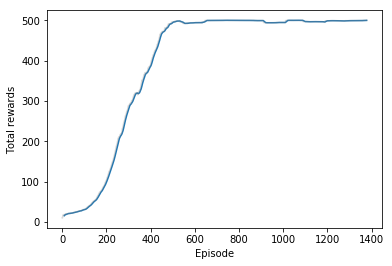

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

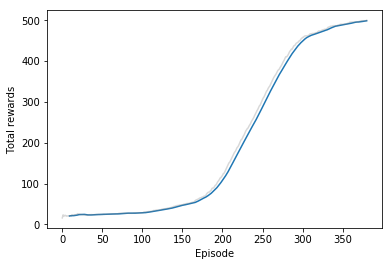

In [59]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

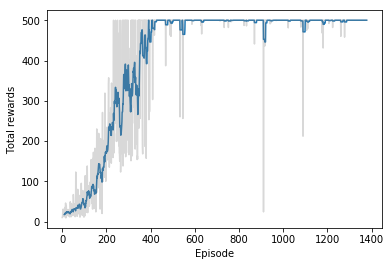

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

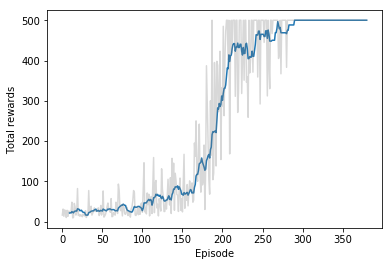

In [61]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 481.0
total_reward: 481.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.